In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.cluster import Birch
from numpy import unique
from numpy import where
from matplotlib import pyplot
from scipy import optimize
import pylab as pl
from itertools import chain
import warnings
from time import time
import yfinance as yf

warnings.filterwarnings("ignore")

# importing dataset

In [2]:
stock_names=['DIS', 'GOOG', 'GOOGL', 'VIAC', 'TMUS', 'TTWO', 'LYV', 'IPG', 'NFLX', 'EA',
 'ATVI', 'CMCSA', 'CHTR', 'DISH', 'LUMN', 'OMC', 'T', 'DISCA', 'VZ', 'DISCK']

y={}
for i in stock_names:
    y[i]=pd.read_csv("{}.csv".format(i))
    y[i] = y[i].iloc[: , 1:]
df=pd.concat(y, axis=1)
df=df.reset_index()

# Adding a new price feature

In [28]:
price=pd.DataFrame()
price["VZ"]=df["VZ"]["Close"]-df["VZ"]["MA_20"]
price["TTWO"]=df["TTWO"]["Close"]-df["TTWO"]["MA_20"]
price["LUMN"]=df["LUMN"]["Close"]-df["LUMN"]["MA_20"]
price["DISH"]=df["DISH"]["Close"]-df["DISH"]["MA_20"]
price["NFLX"]=df["NFLX"]["Close"]-df["NFLX"]["MA_20"]
price["EA"]=df["EA"]["Close"]-df["EA"]["MA_20"]

price

,VZ,TTWO,LUMN,DISH,NFLX,EA
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2512,-0.321001,-0.196008,-0.3030,1.488501,-14.831511,2.603499
2513,0.098001,-5.066502,-0.3925,1.602499,-11.705525,-0.664008
2514,-0.375999,-0.945502,-0.4735,1.089499,-10.605510,0.992997
2515,-0.113501,-1.883996,-0.5025,0.888999,-14.957497,0.835504


# adding industry information to stock data

In [29]:
data = yf.download("^GSPC", period="10y",
        group_by='ticker', actions=False)
data["S&P day_change"]=data["Close"]-data["Open"]
data=data[["Close","Volume"]]
data.reset_index(inplace=True)


sector_index=np.ones((len(df)))
def calculate_return(stock):
    stock["Daily return"]=0
    stock["Cumulative return"]=100
    stock["Cumulative return"].iloc[0]=100
    for i in range(1,len(stock)):
        if stock["Close"].iloc[i-1]>-100:
            stock["Daily return"].iloc[i]=(stock["Close"].iloc[i]-stock["Close"].iloc[i-1])/stock["Close"].iloc[i-1]
            stock["Cumulative return"].iloc[i]=stock["Cumulative return"].iloc[i-1]*(1+stock["Daily return"].iloc[i])
        else:
            stock["Daily return"].iloc[i]=0
            stock["Cumulative return"].iloc[i]=100
    return stock
returns=pd.DataFrame()
for i in stock_names:
    r=calculate_return(df[i])
    returns[i+" Daily return"]=r["Daily return"].copy()
    
data["sector mean of return"]=returns.mean(axis=1)
data["sector deviation of return"]=returns.std(axis=1)
data["Volume"]=(data["Volume"]/data["Volume"].rolling(window=28).mean())

data

[*********************100%***********************]  1 of 1 completed


,Date,Close,Volume,sector mean of return,sector deviation of return
0,2011-08-01,1286.939941,NaN,0.000000,0.000000
1,2011-08-02,1254.050049,NaN,-0.046556,0.076369
2,2011-08-03,1260.339966,NaN,0.006055,0.018640
3,2011-08-04,1200.069946,NaN,-0.054189,0.022092
4,2011-08-05,1199.380005,NaN,-0.007646,0.022170
...,...,...,...,...,...
2512,2021-07-26,4422.299805,0.770980,0.013205,0.016633
2513,2021-07-27,4401.459961,0.976411,-0.011786,0.017363
2514,2021-07-28,4400.640137,0.935599,0.001628,0.011939
2515,2021-07-29,4419.149902,0.848128,0.000772,0.011693


# Exporting datasets to add to final dataset manually

In [36]:
data.to_csv("data.csv")
price.to_csv("price.csv")

# Calculating correlation of stock returns with lag=1 to 10

In [ ]:
import itertools

comb=[]
for subset in itertools.combinations(stock_names, 2):
    comb.append(subset)
u=[]
for s in comb:
    r=pd.DataFrame()
    print(s)
    for i in s:
        r[i]=returns[i+" Daily return"]
    for a in range(1,10):
        r[s[0],a] = r[s[0]].shift(a)
    corr_df = r.corr(method='pearson')
    print(corr_df.iloc[2:,1].max())
    u.append(corr_df.iloc[2:,1].max())



# Convert raw volume to ratio of day's volume to average 50 days volume

In [10]:
y={}
for i in stock_names:
    r=df[i]["Volume"]/df[i]["Volume"].rolling(window=28).mean()
    df.drop((i, 'Volume'), axis = 1, inplace = True)
    y[i]=pd.concat([df[i],r], axis=1)
df=pd.concat(y, axis=1)


# segment close price into trends

In [3]:
def segments_fit(X, Y, maxcount):
    xmin = X.min()
    xmax = X.max()
    
    n = len(X)
    
    AIC_ = float('inf')
    BIC_ = float('inf')
    r_   = None
    
    for count in range(1, maxcount+1):
        
        seg = np.full(count - 1, (xmax - xmin) / count)

        px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.1].mean() for x in px_init])

        def func(p):
            seg = p[:count - 1]
            py = p[count - 1:]
            px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
            return px, py

        def err(p): # This is RSS / n
            px, py = func(p)
            Y2 = np.interp(X, px, py)
            return np.mean((Y - Y2)**2)

        r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    
        # Compute AIC/ BIC. 
        AIC = n * np.log10(err(r.x)) + 4 * count
        BIC = n * np.log10(err(r.x)) + 2 * count * np.log(n)
        
        if((BIC < BIC_) & (AIC < AIC_)): # Continue adding complexity.
            r_ = r
            AIC_ = AIC
            BIC_ = BIC
        else: # Stop.
            count = count - 1
            break
        
    return func(r_.x) ## Return the last (n-1)

In [54]:
plt.rcParams["figure.figsize"] = (18, 12)
def extract_trends(start,s,stock):
    
    points_x=[]
    points_y=[]
    start_day=start
    end_day=2500
    trend_interval_duration=60
    #from where we have data to current date
    for i in range(start_day,end_day,trend_interval_duration):
        if i<(2500-trend_interval_duration):
            Y=stock["Close"].iloc[i:i+trend_interval_duration]
            X=np.arange(i, i+trend_interval_duration, 1)
        else:
            Y=stock["Close"].iloc[i:df.shape[0]]
            X=np.arange(i,df.shape[0], 1)

        points_x.append(segments_fit(X, Y, 20)[0])
        points_y.append(segments_fit(X, Y, 20)[1])

    points_x=list(chain.from_iterable(points_x))
    points_y=list(chain.from_iterable(points_y))
    Y=stock["Close"]
    X=np.arange(0,df.shape[0])
    px=[]
    py=[]
    for i in range(len(points_x)-1):
        if (points_x[i+1]-points_x[i])<=1:
            px.append((points_x[i]+points_x[i+1])/2)
            py.append((points_y[i]+points_y[i+1])/2)
            i+=1
        else:
            px.append(points_x[i])
            py.append(points_y[i])
    px.append(points_x[-1])
    py.append(points_y[-1])       
    for i in range(1,len(px)):
        if i<len(px):
            if (px[i]-start_day)%trend_interval_duration==0:
                del px[i]
                del py[i]
    return px,py


# creat a profitability feature for every day

In [55]:
def voteing_trend(stock):
    trend=pd.DataFrame(df[stock]["Close"])
    trend=trend.rename(columns={'Close':'position'}) 
    rgb_cycle=np.zeros((len(df[stock]),7))
    print(stock)
    for s in range (0,70,10):
        print(s)
        px,py=extract_trends(s,stock,df[stock])
        X=np.zeros((len(px),2))
        X[:,0]=px
        X[:,1]=py
        X=sorted(X, key=lambda x:x[0])
        X=np.array(X)
        px=X[:,0]
        py=X[:,1]
        slopes=[]
        #extracting slopes of each trend and add it to dataset
        for j in range(len(px)-1):
            slopes.append((py[j+1]-py[j])/(px[j+1]-px[j]))
        r=pd.cut(df['index'], bins=px, include_lowest=True, labels=slopes) 
        # exctracing position of each day in its corresponding trend
        for j in range(s,2516):
            trend_start=sorted(i for i in px if i <= j)[-1]
            trend_end=sorted(i for i in px if i >= j)[0]
            if j!=trend_start:
                trend["position"].iloc[j]=-1+2*(j-trend_start)/(trend_end-trend_start)
            else:
                if r[j]<r[j+1]:
                    trend["position"].iloc[j]=1
                else:
                    trend["position"].iloc[j]=-1
        trend["position"].iloc[-1]=1 
        #creating profiabily feature
        for k in range(len(trend["position"])):
            rgb_cycle[k][int(s/10)]=trend["position"].iloc[k]*np.sign(r.iloc[k])      
    return rgb_cycle    

# Calculating return of the srategy

In [56]:
def calculate_return_of_strategy(threshold1,threshold2,close_list,signal_list,stock):

    condlist = [(signal_list<= threshold1),(signal_list> threshold1) & (signal_list< threshold2) ,
                (signal_list >=threshold2)]
    choicelist = [-1,0.5, 1]
    trade_signal = np.select(condlist, choicelist)
    
    portfolio=np.zeros((len(close_list),2))
    buy_and_sell=np.zeros((len(close_list),2))
    portfolio[:,0]=close_list
    portfolio[:,1]=trade_signal
    flag=True
    for i in range(len(portfolio)):
        if flag==True:
            if (portfolio[i,1]==-1) :
                buy_and_sell[i,1]=-1
                buy_and_sell[i,0]=portfolio[i,0]
                flag=False
        else:        
            if (portfolio[i,1]==1) :
                buy_and_sell[i,1]=1 
                buy_and_sell[i,0]=portfolio[i,0]
                flag=True
    buy_and_sell=buy_and_sell[buy_and_sell[:,1]!=0]
    liq=1
    for i in range(0,len(buy_and_sell)-1,2):
        liq=liq*buy_and_sell[i+1,0]/buy_and_sell[i,0]
    return liq-1


# Adding signal label to dataset

In [57]:
df=df.reset_index()
def add_signal(stock):
    init_time = time() 

    y=voteing_trend(stock)
    t=y.mean(axis=1)
    t=pd.Series(t)
    t=-1+2*(t-t.min())/(t.max()-t.min())

    threshold1_list=np.arange(-1,0,0.01)
    threshold2_list=np.arange(0,1,0.01)

    scores=np.zeros((len(threshold1_list)*len(threshold2_list),3))
    c=0
    for i in threshold1_list:
        for j in threshold2_list:
            scores[c,2]=calculate_return_of_strategy(i,j,df[stock]["Close"],t,stock)
            scores[c,0]=i
            scores[c,1]=j
            c+=1
    threshold1=scores[scores[:,2]==scores[:,2].max()][0][0]
    threshold2=scores[scores[:,2]==scores[:,2].max()][0][1]
    training_time = time() - init_time
    condlist = [
        (t <= threshold1),
        (t > threshold1) & (t <= threshold2),
        (t >threshold2)
        ]
    choicelist = [0,1,2]
    labels = np.select(condlist, choicelist)
    labels = pd.Series(labels).rename('label')
    
    print("Training time of stock {}= {:.2f}s".format(stock,training_time))
    print("return using proposed signal:{:.2f}%".format(calculate_return_of_strategy(threshold1,threshold2,df[stock]["Close"],t,stock)*100))
    print("return of buy and hold:{:.2f}%".format(100*(df[stock]["Close"].iloc[-1]-df[stock]["Close"].iloc[0])/df[stock]["Close"].iloc[0]))
    print()
    return labels,threshold1,threshold2


In [ ]:
u=["TTWO","NFLX","EA","DISH","VZ","LUMN"]
y={}
for i in u:
    r,a,b=add_signal(i)
    y[i]=pd.concat([df[i],pd.Series(r).rename("signal")], axis=1)
    y[i].to_csv("1{}.csv".format(i))
df_labeled=pd.concat(y, axis=1)    

# Plotting buy and sell positions

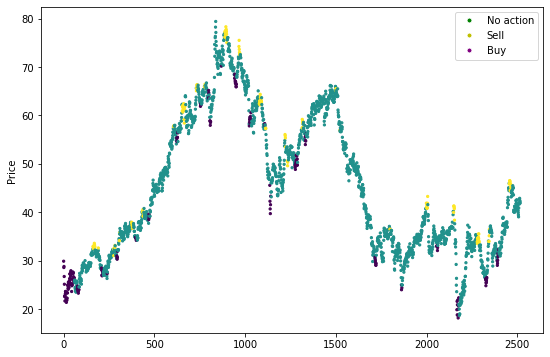

In [59]:
fig, ax = plt.subplots(figsize=(9,6))
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
Y=df_labeled["DISH"]["Close"].iloc[0:]
X=np.arange(0,2517)
ax.scatter(X,Y, c=df_labeled["DISH"]["signal"], s=5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='No action', markerfacecolor='g', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Sell', markerfacecolor='y', markersize=5),
                    Line2D([0], [0], marker='o', color='w', label='Buy', markerfacecolor='purple', markersize=5)]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_ylabel('Price')
fig.show()

# Export dataset 

In [ ]:
for i in stock_names:
    df_labeled[i].to_csv("{}1.csv".format(i))